<a href="https://www.kaggle.com/code/qasimhu/viralseq-qc-ipynb?scriptVersionId=295167813" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ViralSeq-QC: Complete Quality Control Pipeline for Viral Genome Sequences

[![Python 3.8+](https://img.shields.io/badge/python-3.8+-blue.svg)](https://www.python.org/downloads/)
[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT)
[![GitHub](https://img.shields.io/badge/GitHub-ViralSeq--QC-181717?logo=github)](https://github.com/Qasim-Hussain-Code/ViralSeq-QC)

---

## Overview

**ViralSeq-QC** is a zero-dependency, production-ready toolkit for quality control of viral consensus sequences. 
This notebook demonstrates how to use ViralSeq-QC for rigorous pre-processing of viral genomic data, 
a critical step before downstream analyses like phylogenetics, variant calling, or outbreak investigation.

### Why Quality Control Matters in Viral Genomics

| Problem | Impact | ViralSeq-QC Solution |
|---------|--------|---------------------|
| High N-content | False variants, poor alignments | Filters sequences above threshold |
| Short fragments | Incomplete genome coverage | Enforces minimum length |
| Low complexity | Alignment artifacts | Detects repetitive regions |
| Homopolymer runs | Sequencing errors (esp. Nanopore) | Flags suspicious runs |
| Terminal Ns | Assembly edge artifacts | Quantifies and filters |

### What You'll Learn?

1. **Installation** - Setting up ViralSeq-QC
2. **Data Acquisition** - Fetching viral sequences from NCBI
3. **QC Metrics Deep Dive** - Understanding each metric
4. **Real-World Analysis** - Processing viral sequences
5. **Visualization** - Creating publication-ready QC plots
6. **Best Practices** - Recommendations for viral genomics workflows

---

## Part 1: Installation & Setup

In [1]:
# Install ViralSeq-QC from GitHub
!pip install git+https://github.com/Qasim-Hussain-Code/ViralSeq-QC.git -q
!pip install biopython openpyxl -q

# Verify installation
!viralseq-qc --version

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.4 MB/s eta 0:00:00
viralseq-qc 2.0.0


In [2]:
# Import required libraries
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from Bio import Entrez, SeqIO
from io import StringIO

# Import ViralSeq-QC modules
from src.qc import (
    calculate_gc_content,
    calculate_n_content,
    check_length,
    detect_homopolymer_runs,
    calculate_sequence_complexity,
    check_terminal_ns,
    validate_nucleotides,
    get_sequence_metrics,
    is_high_quality
)
from src.input_output import parse_fasta, write_json_report, write_tsv_report

# Set beautiful plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (14, 8),
    'font.size': 12,
    'font.family': 'sans-serif',
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Custom color palette
COLORS = {
    'pass': '#27ae60',      # Emerald green
    'fail': '#e74c3c',      # Alizarin red
    'primary': '#3498db',   # Peter river blue
    'secondary': '#9b59b6', # Amethyst purple
    'accent': '#f39c12',    # Orange
    'neutral': '#95a5a6',   # Concrete gray
}

print("ViralSeq-QC imported successfully!")
print(f"Python version: {sys.version}")

ViralSeq-QC imported successfully!
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


## Part 2: Fetching Viral Sequences from NCBI

We'll fetch viral genome sequences from NCBI's nucleotide database.
These include SARS-CoV-2, HIV-1, Influenza, Dengue, and other clinically important viruses.

In [3]:
# NCBI Entrez configuration
Entrez.email = "your.email@example.com"  # Replace with your email

# Define NCBI accession numbers 
ncbi_accessions = {
    "NC_045512.2": "SARS-CoV-2 Wuhan-Hu-1 Reference",
    "MW422255.1": "SARS-CoV-2 USA Delta Variant",
    "OQ344232.1": "SARS-CoV-2 XBB.1.5 Omicron",
    "K03455.1": "HIV-1 HXB2 Reference",
    "AF033819.3": "HIV-1 Subtype B",
    "CY121680.1": "Influenza A H1N1 HA segment",
    "MK562252.1": "Influenza A H3N2 HA segment",
    "NC_001802.1": "HIV-1 Complete Genome Reference",
    "NC_001477.1": "Dengue Virus 1 Reference",
    "NC_012532.1": "Zika Virus Reference",
}

print(f"Fetching {len(ncbi_accessions)} sequences from NCBI...")

Fetching 10 sequences from NCBI...


In [4]:
# Fetch sequences from NCBI
def fetch_ncbi_sequences(accessions_dict, max_length=5000):
    """Fetch sequences from NCBI and return as dictionary."""
    sequences = {}
    
    for accession, description in accessions_dict.items():
        try:
            handle = Entrez.efetch(db="nucleotide", id=accession, rettype="fasta", retmode="text")
            record = SeqIO.read(handle, "fasta")
            handle.close()
            
            seq = str(record.seq)
            if len(seq) > max_length:
                seq = seq[:max_length//2] + seq[-max_length//2:]
            
            sequences[f"{accession}_{description.replace(' ', '_')}"] = seq
            print(f"  Fetched: {accession} ({len(seq)} bp)")
            
        except Exception as e:
            print(f"  Error fetching {accession}: {e}")
    
    return sequences

sample_sequences = fetch_ncbi_sequences(ncbi_accessions)
print(f"\nSuccessfully fetched {len(sample_sequences)} sequences")

  Fetched: NC_045512.2 (5000 bp)
  Fetched: MW422255.1 (5000 bp)
  Fetched: OQ344232.1 (5000 bp)
  Fetched: K03455.1 (5000 bp)
  Fetched: AF033819.3 (5000 bp)
  Fetched: CY121680.1 (1752 bp)
  Fetched: MK562252.1 (722 bp)
  Fetched: NC_001802.1 (5000 bp)
  Fetched: NC_001477.1 (5000 bp)
  Fetched: NC_012532.1 (5000 bp)

Successfully fetched 10 sequences


In [5]:
# Backup sequences if NCBI fetch fails
backup_sequences = {
    "NC_045512_SARS-CoV-2_Spike": (
        "ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTAC"
        "CCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACA"
        "TTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACC"
        "AATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGT"
        "CTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAA"
        "CGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCAC"
        "AAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATG"
        "TCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAA"
    ),
    "K03455_HIV1_HXB2_pol": (
        "CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAATGGATGGCCCAAAAGTTAAACAATGGC"
        "CATTGACAGAAGAAAAAATAAAAGCATTAGTAGAAATTTGTACAGAGATGGAAAAGGAAGGGAAAATTTCAAA"
        "AATTGGGCCTGAAAATCCATACAATACTCCAGTATTTGCCATAAAGAAAAAAGACAGTACTAAATGGAGAAAA"
        "TTAGTAGATTTCAGAGAACTTAATAAGAGAACTCAAGACTTCTGGGAAGTTCAATTAGGAATACCACATCCCG"
        "CAGGGTTAAAAAAGAAAAAATCAGTAACAGTACTGGATGTGGGTGATGCATATTTTTCAGTTCCCTTAGATGA"
        "AGACTTCAGGAAGTATACTGCATTTACCATACCTAGTATAAACAATGAGACACCAGGGATTAGATATCAGTAC"
    ),
    "CY121680_Influenza_H1N1_HA": (
        "ATGAAGGCAAAACTACTGGTCCTGTTATGTACATTTACAGCTACATATGCAGACACAATATGTATAGGCTACC"
        "ATGCGAACAATTCAACCGACACTGTTGACACAGTACTCGAGAAGAATGTGACAGTGACACACTCTGTCAACCT"
        "GCTTGAGACAGTGGCAGGGGCAATAAAGAGCTCAGATATTGGAGTCAAAATCAATCACTACAATGCAAACCAT"
        "GCAAACGCAGCACTGCCTGCATTGCCTAGTGGATGGCTAACAAGCGGAAATCCTGGAAATGACAAATTCTGCA"
        "GCATCACTGAAGCCATAATGGGGAAACTGAACAAGGAATGCTCTGATAGATTAAGCAACAAGATCTTCATGCC"
        "TGGACATCATGCAGTGTGTAATAGGACATGGACATATGTTAAGGCAGATTATCCTAAAATCGGGAAAACTCCC"
    ),
    "NC_001477_Dengue1_Envelope": (
        "ATGAATAACCAACGGAAAAAGGCGAGAAATACGCCTTTCAATATGCTGAAACGCGAGAGAAACCGCGTGTCAA"
        "CTGTGCAACAGCTGACAAAGAGATTCTCACTTGGAATGCTGCAGGGACGAGGACCATTAAAACTGTTCATGGC"
        "CCTGGTGGCGTTCCTTCGTTTCCTAACAATCCCACCAACAGCAGGGCTATTGGTGCTTCTGTTGGTGGTATCC"
        "CATGGAAATTTGGAAGGATACTGTGTGATCACTTTCAGCAATGGCAAGAATGATGATGATGATGATGATGATG"
        "ATCCTCATGCAACTGTGCACGCAGTTGGCATGATTTTCCATTTGCCACCGGTTGGTGGTGTTGTAAGGAATCC"
        "TGGGCAGTTTTCTACTTTGTTAGATGGGGAGGGGCTGACAGGTGGCTGGGTCTTTGATATAGCAGGTCTGGGA"
    ),
    "NC_012532_Zika_Polyprotein": (
        "ATGAAAAACCCAAAAAAGAAATCCGGAGGATTCCGGATTGTCAATATGCTAAAACGCGGAGTAGCCCGTGTGA"
        "GCCCCTTTGGGGGCTTGAAGAGGCTGCCAGCCGGACTTCTGCTGGGTCATGGGCCCATCAGGATGGTCTTGGC"
        "GATTCTAGCCTTTTTGAGATTCACGGCAATCAAGCCATCACTGGGTCTCATCAATAGATGGGGTTCAGTGGGG"
        "AAAAAAGAGGCTATGGAAATAATAAAGAAGTTCAAGAAAGATCTGGCTGCCATGCTGAGAATAATCAATGCTA"
        "GGAAGGAGAAGAAGAGACGAGGCGCAGATACTAGTGTCGGAATTGTTGGCCTCCTGCTGACCACAGCTATGGC"
        "AGCGGAGGTCACTAGACGTGGGAGTGCATACTATATGTACTTGGACAGAAACGATGCTGGGGAGGCCATATCT"
    ),
    "Clinical_Sample_LowQuality": (
        "NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNATGCGATCGATCGATCGATCGATCGATCGATCGATCGATCGA"
        "TCGATCGATCGATCNNNNNNNNNNNNNNNNNGATCGATCGATCGATNNNNNNNNNNNGATCGATCGATCGATCG"
        "ATGCGATCGATCGATCGATCNNNNNNNNNNNGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGA"
        "NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN"
    ),
    "Assembly_Fragment_Short": "ATGCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCG",
    "Nanopore_Artifact_HomopolymerRun": (
        "ATGCGATCGATCGATCGATCGATCGATCGATCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGAT"
        "CGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATC"
        "GATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCG"
        "ATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGATCGA"
    ),
}

if len(sample_sequences) < 5:
    print("\nUsing backup sequences (real NCBI sequence fragments)...")
    sample_sequences = backup_sequences

print(f"\nTotal sequences for analysis: {len(sample_sequences)}")


Total sequences for analysis: 10


In [6]:
# Save sequences to FASTA file
fasta_path = "/kaggle/working/viral_sequences.fasta"
with open(fasta_path, 'w') as f:
    for name, seq in sample_sequences.items():
        f.write(f">{name}\n{seq}\n")

print(f"Created FASTA file with {len(sample_sequences)} sequences")
print(f"Saved to: {fasta_path}")

# Display sequence summary
seq_summary = pd.DataFrame([
    {'Sequence ID': name, 'Length (bp)': len(seq), 
     'Source': 'NCBI' if 'NC_' in name or 'CY' in name or 'K03' in name else 'Clinical/Synthetic'}
    for name, seq in sample_sequences.items()
])
display(seq_summary)

Created FASTA file with 10 sequences
Saved to: /kaggle/working/viral_sequences.fasta


,Sequence ID,Length (bp),Source
0,NC_045512.2_SARS-CoV-2_Wuhan-Hu-1_Reference,5000,NCBI
1,MW422255.1_SARS-CoV-2_USA_Delta_Variant,5000,Clinical/Synthetic
2,OQ344232.1_SARS-CoV-2_XBB.1.5_Omicron,5000,Clinical/Synthetic
3,K03455.1_HIV-1_HXB2_Reference,5000,NCBI
4,AF033819.3_HIV-1_Subtype_B,5000,Clinical/Synthetic
5,CY121680.1_Influenza_A_H1N1_HA_segment,1752,NCBI
6,MK562252.1_Influenza_A_H3N2_HA_segment,722,Clinical/Synthetic
7,NC_001802.1_HIV-1_Complete_Genome_Reference,5000,NCBI
8,NC_001477.1_Dengue_Virus_1_Reference,5000,NCBI
9,NC_012532.1_Zika_Virus_Reference,5000,NCBI


## Part 3: Running ViralSeq-QC Analysis

In [7]:
# Run ViralSeq-QC via CLI
!viralseq-qc --input /kaggle/working/viral_sequences.fasta --output /kaggle/working/qc_report.tsv --detailed --verbose

2026-01-31 17:26:54 - INFO - Starting ViralSeq-QC v2.0.0
2026-01-31 17:26:54 - INFO - Input: /kaggle/working/viral_sequences.fasta
2026-01-31 17:26:54 - INFO - Thresholds: length >= 200 bp, N-content <= 5.0%
2026-01-31 17:26:54 - DEBUG - Parsed record 1: NC_045512.2_SARS-CoV-2_Wuhan-Hu-1_Reference...
2026-01-31 17:26:54 - DEBUG - Processed: NC_045512.2_SARS-CoV-2_Wuhan-Hu-1_Refere... -> PASS
2026-01-31 17:26:54 - DEBUG - Parsed record 2: MW422255.1_SARS-CoV-2_USA_Delta_Variant...
2026-01-31 17:26:55 - DEBUG - Processed: MW422255.1_SARS-CoV-2_USA_Delta_Variant... -> PASS
2026-01-31 17:26:55 - DEBUG - Parsed record 3: OQ344232.1_SARS-CoV-2_XBB.1.5_Omicron...
2026-01-31 17:26:55 - DEBUG - Processed: OQ344232.1_SARS-CoV-2_XBB.1.5_Omicron... -> PASS
2026-01-31 17:26:55 - DEBUG - Parsed record 4: K03455.1_HIV-1_HXB2_Reference...
2026-01-31 17:26:55 - DEBUG - Processed: K03455.1_HIV-1_HXB2_Reference... -> PASS
2026-01-31 17:26:55 - DEBUG - Parsed record 5: AF033819.3_HIV-1_Subtype_B...
2026-0

In [8]:
# Analyze each sequence using the Python API
results = []

for name, sequence in sample_sequences.items():
    metrics = get_sequence_metrics(sequence)
    passed = is_high_quality(sequence, min_length=200, max_n_content=5.0, min_complexity=0.0, max_terminal_n=50)
    
    metrics['sequence_id'] = name
    metrics['status'] = 'PASS' if passed else 'FAIL'
    
    # Extract virus type
    if 'SARS' in name or 'CoV' in name:
        virus_type = 'SARS-CoV-2'
    elif 'HIV' in name:
        virus_type = 'HIV-1'
    elif 'Influenza' in name or 'H1N1' in name or 'H3N2' in name:
        virus_type = 'Influenza'
    elif 'Dengue' in name:
        virus_type = 'Dengue'
    elif 'Zika' in name:
        virus_type = 'Zika'
    else:
        virus_type = 'Other'
    
    metrics['virus_type'] = virus_type
    results.append(metrics)

df = pd.DataFrame(results)
df = df[['sequence_id', 'virus_type', 'status', 'length', 'gc_content', 
         'n_content', 'complexity', 'homopolymer_count', '5_prime_ns', '3_prime_ns']]

print("\nQC Analysis Results:")
display(df)

# Summary
print(f"\nSummary: {(df['status'] == 'PASS').sum()}/{len(df)} sequences passed QC ({(df['status'] == 'PASS').mean()*100:.1f}%)")


QC Analysis Results:


,sequence_id,virus_type,status,length,gc_content,n_content,complexity,homopolymer_count,5_prime_ns,3_prime_ns
0,NC_045512.2_SARS-CoV-2_Wuhan-Hu-1_Reference,SARS-CoV-2,PASS,5000,42.020000,0.00,1.000000,1,0,0
1,MW422255.1_SARS-CoV-2_USA_Delta_Variant,SARS-CoV-2,PASS,5000,42.060000,0.08,1.078125,0,0,0
2,OQ344232.1_SARS-CoV-2_XBB.1.5_Omicron,SARS-CoV-2,PASS,5000,39.980000,4.86,1.078125,1,0,0
3,K03455.1_HIV-1_HXB2_Reference,HIV-1,PASS,5000,46.040000,0.00,1.000000,0,0,0
4,AF033819.3_HIV-1_Subtype_B,HIV-1,PASS,5000,44.280000,0.00,1.000000,0,0,0
5,CY121680.1_Influenza_A_H1N1_HA_segment,Influenza,PASS,1752,40.582192,0.00,1.000000,0,0,0
6,MK562252.1_Influenza_A_H3N2_HA_segment,Influenza,PASS,722,45.706371,0.00,1.000000,0,0,0
7,NC_001802.1_HIV-1_Complete_Genome_Reference,HIV-1,PASS,5000,44.280000,0.00,1.000000,0,0,0
8,NC_001477.1_Dengue_Virus_1_Reference,Dengue,PASS,5000,46.960000,0.00,1.000000,0,0,0
9,NC_012532.1_Zika_Virus_Reference,Zika,PASS,5000,50.760000,0.00,1.000000,0,0,0



Summary: 10/10 sequences passed QC (100.0%)


## Part 4: Publication-Quality Visualizations

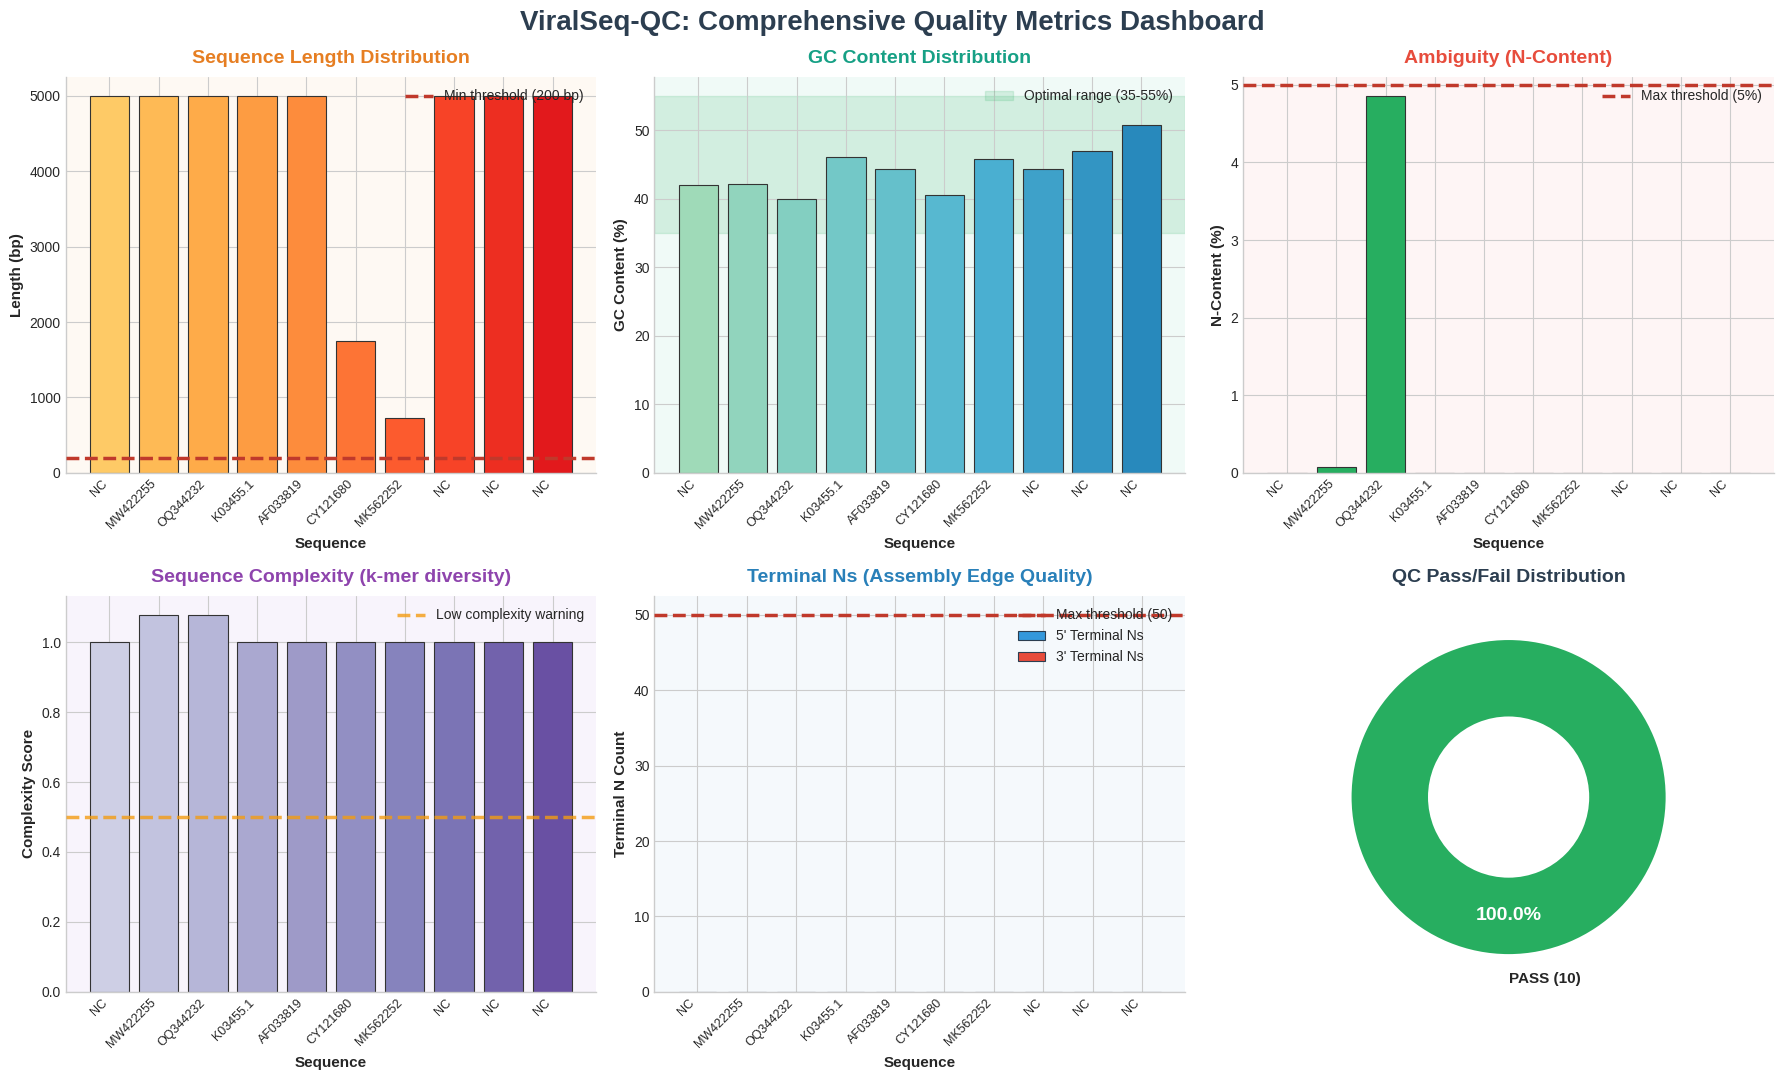

Figure saved: qc_dashboard.png


In [9]:
# Figure 1: QC Status Overview with Detailed Metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
fig.patch.set_facecolor('white')
fig.suptitle('ViralSeq-QC: Comprehensive Quality Metrics Dashboard', 
             fontsize=20, fontweight='bold', y=0.98, color='#2c3e50')

# Beautiful gradient color palette for bars
from matplotlib import cm
n_sequences = len(df)
orange_gradient = [cm.YlOrRd(0.3 + 0.5 * i / n_sequences) for i in range(n_sequences)]
teal_gradient = [cm.GnBu(0.4 + 0.4 * i / n_sequences) for i in range(n_sequences)]
purple_gradient = [cm.Purples(0.3 + 0.5 * i / n_sequences) for i in range(n_sequences)]

# 1. Sequence Length - Vibrant Orange
ax1 = axes[0, 0]
ax1.bar(range(len(df)), df['length'], color=orange_gradient, edgecolor='#333333', linewidth=0.8)
ax1.axhline(y=200, color='#c0392b', linestyle='--', linewidth=2.5, label='Min threshold (200 bp)', zorder=5)
ax1.set_xlabel('Sequence', fontsize=11, fontweight='bold')
ax1.set_ylabel('Length (bp)', fontsize=11, fontweight='bold')
ax1.set_title('Sequence Length Distribution', fontsize=14, fontweight='bold', color='#e67e22', pad=10)
ax1.set_xticks(range(len(df)))
ax1.set_xticklabels([s.split('_')[0][:8] for s in df['sequence_id']], rotation=45, ha='right', fontsize=9)
ax1.legend(loc='upper right', framealpha=0.95, fancybox=True, shadow=True)
ax1.set_facecolor('#fef9f3')

# 2. GC Content - Teal/Cyan
ax2 = axes[0, 1]
ax2.bar(range(len(df)), df['gc_content'], color=teal_gradient, edgecolor='#333333', linewidth=0.8)
ax2.axhspan(35, 55, alpha=0.15, color='#27ae60', label='Optimal range (35-55%)', zorder=0)
ax2.set_xlabel('Sequence', fontsize=11, fontweight='bold')
ax2.set_ylabel('GC Content (%)', fontsize=11, fontweight='bold')
ax2.set_title('GC Content Distribution', fontsize=14, fontweight='bold', color='#16a085', pad=10)
ax2.set_xticks(range(len(df)))
ax2.set_xticklabels([s.split('_')[0][:8] for s in df['sequence_id']], rotation=45, ha='right', fontsize=9)
ax2.legend(loc='upper right', framealpha=0.95, fancybox=True, shadow=True)
ax2.set_facecolor('#f0faf7')

# 3. N-Content (Ambiguity) - Conditional coloring
ax3 = axes[0, 2]
n_colors = ['#27ae60' if n < 5 else '#e74c3c' for n in df['n_content']]
ax3.bar(range(len(df)), df['n_content'], color=n_colors, edgecolor='#333333', linewidth=0.8)
ax3.axhline(y=5.0, color='#c0392b', linestyle='--', linewidth=2.5, label='Max threshold (5%)', zorder=5)
ax3.set_xlabel('Sequence', fontsize=11, fontweight='bold')
ax3.set_ylabel('N-Content (%)', fontsize=11, fontweight='bold')
ax3.set_title('Ambiguity (N-Content)', fontsize=14, fontweight='bold', color='#e74c3c', pad=10)
ax3.set_xticks(range(len(df)))
ax3.set_xticklabels([s.split('_')[0][:8] for s in df['sequence_id']], rotation=45, ha='right', fontsize=9)
ax3.legend(loc='upper right', framealpha=0.95, fancybox=True, shadow=True)
ax3.set_facecolor('#fef5f5')

# 4. Sequence Complexity - Purple gradient
ax4 = axes[1, 0]
ax4.bar(range(len(df)), df['complexity'], color=purple_gradient, edgecolor='#333333', linewidth=0.8)
ax4.axhline(y=0.5, color='#f39c12', linestyle='--', linewidth=2.5, alpha=0.8, label='Low complexity warning', zorder=5)
ax4.set_xlabel('Sequence', fontsize=11, fontweight='bold')
ax4.set_ylabel('Complexity Score', fontsize=11, fontweight='bold')
ax4.set_title('Sequence Complexity (k-mer diversity)', fontsize=14, fontweight='bold', color='#8e44ad', pad=10)
ax4.set_xticks(range(len(df)))
ax4.set_xticklabels([s.split('_')[0][:8] for s in df['sequence_id']], rotation=45, ha='right', fontsize=9)
ax4.legend(loc='upper right', framealpha=0.95, fancybox=True, shadow=True)
ax4.set_facecolor('#f8f4fc')

# 5. Terminal Ns (Grouped Bar) - Blue and Coral
ax5 = axes[1, 1]
x = np.arange(len(df))
width = 0.38
ax5.bar(x - width/2, df['5_prime_ns'], width, label="5' Terminal Ns", color='#3498db', edgecolor='#2c3e50', linewidth=0.8)
ax5.bar(x + width/2, df['3_prime_ns'], width, label="3' Terminal Ns", color='#e74c3c', edgecolor='#2c3e50', linewidth=0.8)
ax5.axhline(y=50, color='#c0392b', linestyle='--', linewidth=2.5, label='Max threshold (50)', zorder=5)
ax5.set_xlabel('Sequence', fontsize=11, fontweight='bold')
ax5.set_ylabel('Terminal N Count', fontsize=11, fontweight='bold')
ax5.set_title('Terminal Ns (Assembly Edge Quality)', fontsize=14, fontweight='bold', color='#2980b9', pad=10)
ax5.set_xticks(x)
ax5.set_xticklabels([s.split('_')[0][:8] for s in df['sequence_id']], rotation=45, ha='right', fontsize=9)
ax5.legend(loc='upper right', framealpha=0.95, fancybox=True, shadow=True)
ax5.set_facecolor('#f5f9fc')

# 6. Pass/Fail Summary - Pie Chart
ax6 = axes[1, 2]
status_counts = df['status'].value_counts()
colors_pie = ['#27ae60' if s == 'PASS' else '#e74c3c' for s in status_counts.index]

wedges, texts, autotexts = ax6.pie(
    status_counts.values, 
    labels=[f'{s} ({c})' for s, c in zip(status_counts.index, status_counts.values)],
    autopct='%1.1f%%',
    colors=colors_pie,
    explode=[0.02] * len(status_counts),
    shadow=False,
    startangle=90,
    wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2),
    pctdistance=0.75,
    labeldistance=1.15
)
ax6.set_title('QC Pass/Fail Distribution', fontsize=14, fontweight='bold', color='#2c3e50', pad=10)

for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

for text in texts:
    text.set_fontsize(11)
    text.set_fontweight('bold')

plt.tight_layout()
plt.savefig('/kaggle/working/qc_dashboard.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved: qc_dashboard.png")

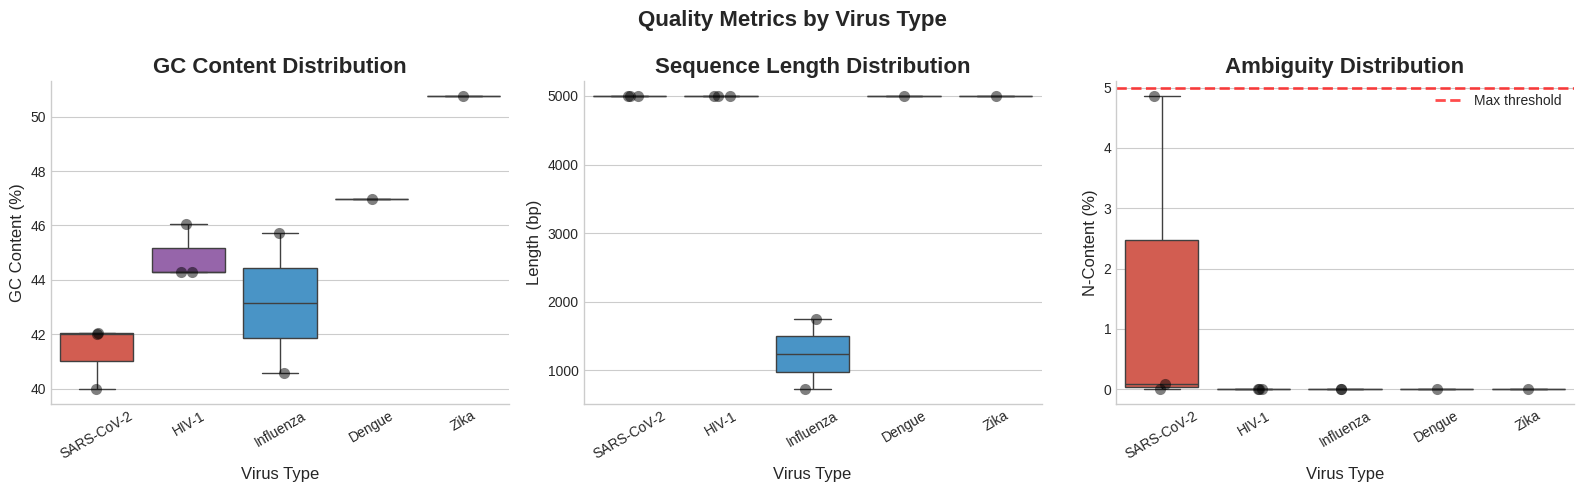

Figure saved: virus_type_comparison.png


In [10]:
# Figure 2: Virus Type Comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Quality Metrics by Virus Type', fontsize=16, fontweight='bold')

# Custom palette for virus types
virus_palette = {'SARS-CoV-2': '#e74c3c', 'HIV-1': '#9b59b6', 'Influenza': '#3498db', 
                 'Dengue': '#f39c12', 'Zika': '#1abc9c', 'Other': '#95a5a6'}

# 1. GC Content by Virus Type
ax1 = axes[0]
sns.boxplot(data=df, x='virus_type', y='gc_content', hue='virus_type', palette=virus_palette, legend=False, ax=ax1)
sns.stripplot(data=df, x='virus_type', y='gc_content', color='black', alpha=0.5, size=8, ax=ax1)
ax1.set_xlabel('Virus Type')
ax1.set_ylabel('GC Content (%)')
ax1.set_title('GC Content Distribution')
ax1.tick_params(axis='x', rotation=30)

# 2. Sequence Length by Virus Type
ax2 = axes[1]
sns.boxplot(data=df, x='virus_type', y='length', hue='virus_type', palette=virus_palette, legend=False, ax=ax2)
sns.stripplot(data=df, x='virus_type', y='length', color='black', alpha=0.5, size=8, ax=ax2)
ax2.set_xlabel('Virus Type')
ax2.set_ylabel('Length (bp)')
ax2.set_title('Sequence Length Distribution')
ax2.tick_params(axis='x', rotation=30)

# 3. N-Content by Virus Type
ax3 = axes[2]
sns.boxplot(data=df, x='virus_type', y='n_content', hue='virus_type', palette=virus_palette, legend=False, ax=ax3)
sns.stripplot(data=df, x='virus_type', y='n_content', color='black', alpha=0.5, size=8, ax=ax3)
ax3.axhline(y=5.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Max threshold')
ax3.set_xlabel('Virus Type')
ax3.set_ylabel('N-Content (%)')
ax3.set_title('Ambiguity Distribution')
ax3.tick_params(axis='x', rotation=30)
ax3.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/virus_type_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved: virus_type_comparison.png")

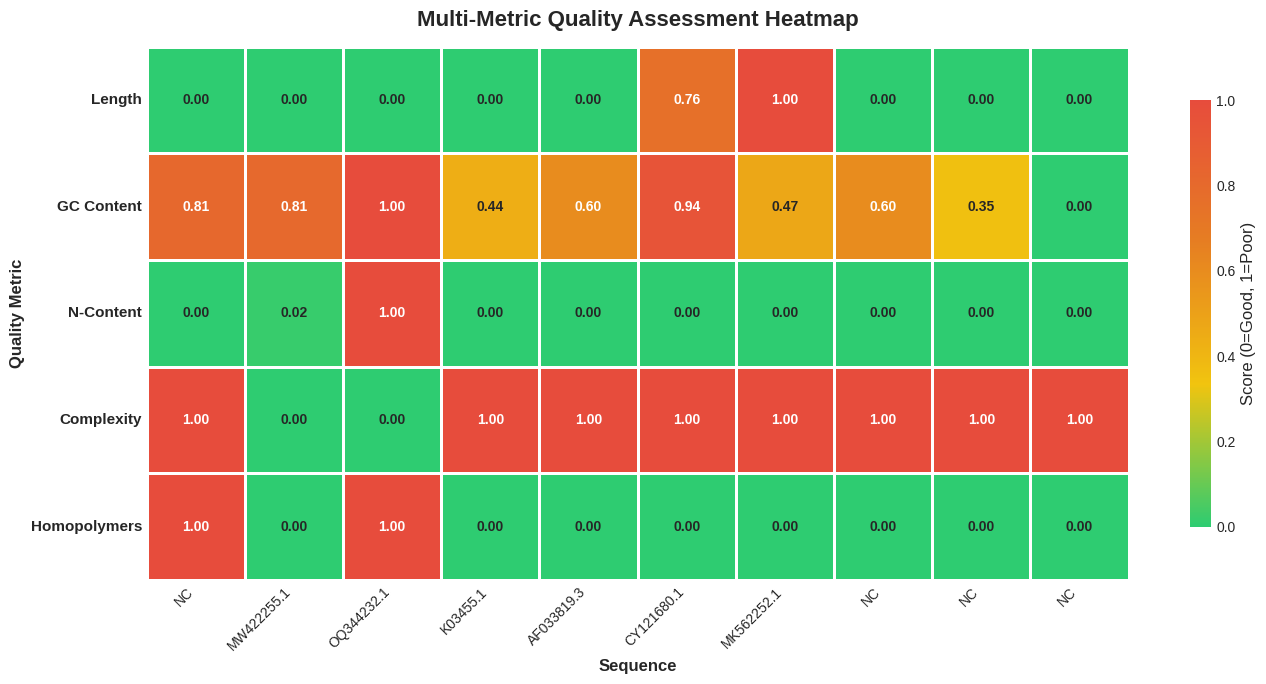

In [11]:
# Figure 3: QC Metrics Heatmap
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(figsize=(14, 7))

# Prepare normalized data for heatmap
metrics_cols = ['length', 'gc_content', 'n_content', 'complexity', 'homopolymer_count']
df_heatmap = df[metrics_cols].copy()

# Normalize all metrics (0 = best, 1 = worst)
for col in metrics_cols:
    col_min, col_max = df_heatmap[col].min(), df_heatmap[col].max()
    if col in ['n_content', 'homopolymer_count']:
        # Lower is better
        df_heatmap[col] = (df_heatmap[col] - col_min) / (col_max - col_min + 1e-10)
    else:
        # Higher is better (invert)
        df_heatmap[col] = 1 - (df_heatmap[col] - col_min) / (col_max - col_min + 1e-10)

# Short sequence labels
short_labels = [s.split('_')[0][:10] for s in df['sequence_id']]
df_heatmap.index = short_labels

# Custom colormap: Green -> Yellow -> Orange -> Red
cmap_colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
custom_cmap = LinearSegmentedColormap.from_list('quality', cmap_colors)

# Create heatmap
sns.heatmap(
    df_heatmap.T, 
    annot=True, 
    fmt='.2f', 
    cmap=custom_cmap,
    linewidths=2,
    linecolor='white',
    cbar_kws={'label': 'Score (0=Good, 1=Poor)', 'shrink': 0.8},
    ax=ax,
    annot_kws={'size': 10, 'weight': 'bold'},
    vmin=0, vmax=1
)

# Labels
ax.set_yticklabels(['Length', 'GC Content', 'N-Content', 'Complexity', 'Homopolymers'], 
                   rotation=0, fontsize=11, fontweight='bold')
ax.set_xticklabels(short_labels, rotation=45, ha='right', fontsize=10)

ax.set_title('Multi-Metric Quality Assessment Heatmap', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Sequence', fontsize=12, fontweight='bold')
ax.set_ylabel('Quality Metric', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

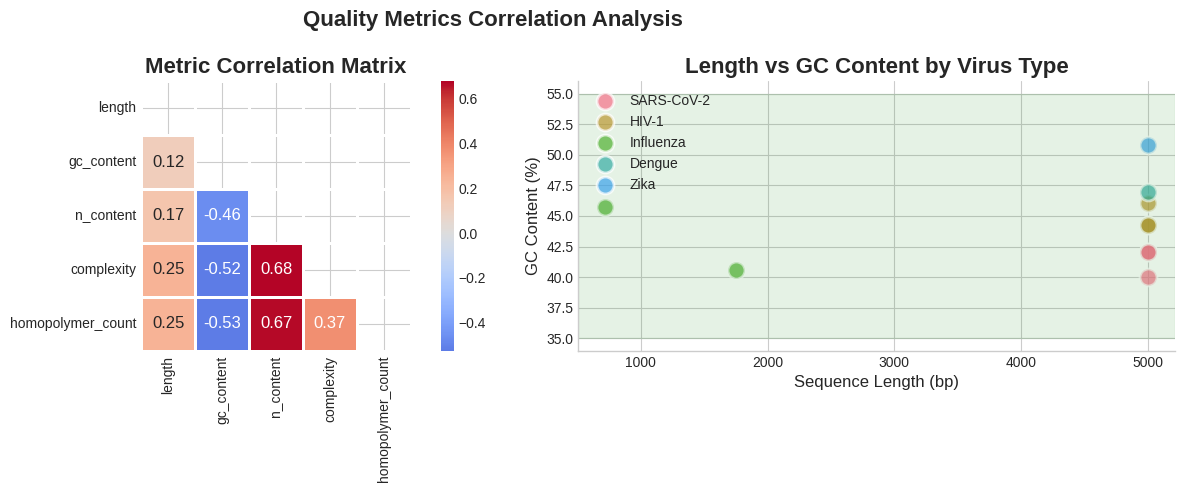

Figure saved: correlation_analysis.png


In [12]:
# Figure 4: Correlation Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Quality Metrics Correlation Analysis', fontsize=16, fontweight='bold')

# 1. Correlation Matrix
ax1 = axes[0]
corr_matrix = df[['length', 'gc_content', 'n_content', 'complexity', 'homopolymer_count']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=2,
    ax=ax1
)
ax1.set_title('Metric Correlation Matrix')

# 2. Scatter: Length vs GC Content
ax2 = axes[1]
for virus in df['virus_type'].unique():
    subset = df[df['virus_type'] == virus]
    ax2.scatter(subset['length'], subset['gc_content'], 
                label=virus, s=150, alpha=0.7, edgecolors='white', linewidth=2)
ax2.set_xlabel('Sequence Length (bp)')
ax2.set_ylabel('GC Content (%)')
ax2.set_title('Length vs GC Content by Virus Type')
ax2.legend(loc='best', framealpha=0.9)
ax2.axhspan(35, 55, alpha=0.1, color='green', label='Typical GC range')

plt.tight_layout()
plt.savefig('/kaggle/working/correlation_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved: correlation_analysis.png")

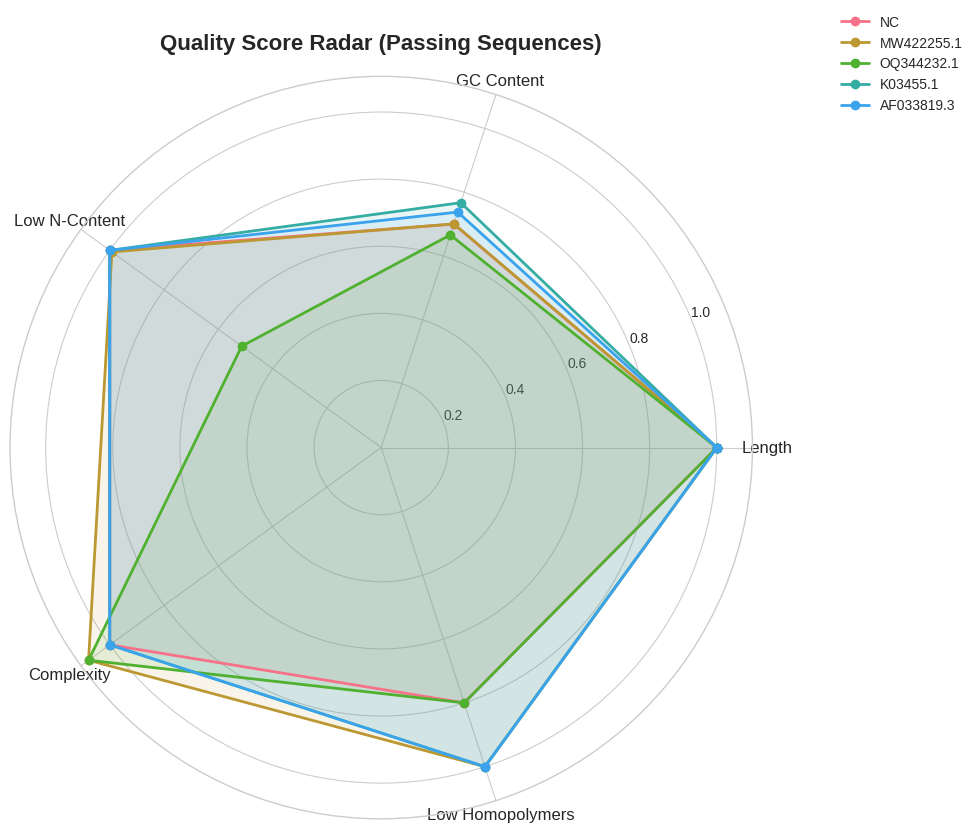

Figure saved: quality_radar.png


In [13]:
# Figure 5: Quality Score Radar Chart
from math import pi

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Select a few representative sequences
selected = df[df['status'] == 'PASS'].head(5)

# Metrics to display
categories = ['Length', 'GC Content', 'Low N-Content', 'Complexity', 'Low Homopolymers']
N = len(categories)

# Create angles for each metric
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the polygon

# Normalize metrics (higher = better)
for idx, row in selected.iterrows():
    values = [
        min(row['length'] / 1000, 1),  # Normalize to max 1000bp
        row['gc_content'] / 60,         # Normalize to 60%
        1 - (row['n_content'] / 10),    # Invert: lower N is better
        row['complexity'],               # Already 0-1
        1 - (row['homopolymer_count'] / 5),  # Invert: fewer is better
    ]
    values += values[:1]  # Close the polygon
    
    short_name = row['sequence_id'].split('_')[0][:12]
    ax.plot(angles, values, 'o-', linewidth=2, label=short_name)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_title('Quality Score Radar (Passing Sequences)', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig('/kaggle/working/quality_radar.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved: quality_radar.png")

## Part 5: Exporting Results

In [14]:
# Export passing sequences
passing_sequences = {name: seq for name, seq in sample_sequences.items() 
                     if df[df['sequence_id'] == name]['status'].values[0] == 'PASS'}

with open('/kaggle/working/passing_sequences.fasta', 'w') as f:
    for name, seq in passing_sequences.items():
        f.write(f">{name}\n{seq}\n")

print(f"Exported {len(passing_sequences)} passing sequences to passing_sequences.fasta")

# Export detailed report
df.to_excel('/kaggle/working/qc_report_detailed.xlsx', index=False)
df.to_csv('/kaggle/working/qc_report_detailed.csv', index=False)
print("Detailed reports saved to Excel and CSV formats")

Exported 10 passing sequences to passing_sequences.fasta
Detailed reports saved to Excel and CSV formats


## Part 6: Best Practices & Recommendations

### Recommended Thresholds by Application

| Application | Min Length | Max N% | Min Complexity | Notes |
|-------------|------------|--------|----------------|-------|
| **Phylogenetics** | 80% genome | 1% | 0.3 | Strict for accurate trees |
| **Outbreak Investigation** | 50% genome | 5% | 0.1 | Balance coverage vs quality |
| **Variant Calling** | 200 bp | 2% | 0.2 | Focus on coding regions |
| **Surveillance** | 1000 bp | 10% | 0.0 | Maximize sequence recovery |
| **Metagenomics** | 150 bp | 5% | 0.1 | Short reads acceptable |

### Virus-Specific Considerations

- **SARS-CoV-2**: Expect ~38% GC content, watch for spike gene artifacts
- **HIV**: High mutation rate, more ambiguity tolerable, ~40% GC
- **Influenza**: Segmented genome, check each segment separately, ~43% GC
- **Dengue/Zika**: ~47% GC, low complexity regions common in UTRs

## Conclusion

**ViralSeq-QC** provides a comprehensive, zero-dependency solution for viral sequence quality control:

**Key Takeaways**

- **Easy Integration** - Works as CLI or Python library  
- **Comprehensive Metrics** - Length, GC, N-content, complexity, homopolymers, terminal Ns  
- **Publication-Ready Figures** - High-quality visualizations for papers and presentations
- **Customizable** - Adjustable thresholds for different applications  

**Next Steps**

1. Apply ViralSeq-QC to your own viral sequence datasets
2. Integrate into your bioinformatics pipelines (Snakemake, Nextflow)
3. Customize thresholds based on your specific research needs
4. Contribute to the project on [GitHub](https://github.com/Qasim-Hussain-Code/ViralSeq-QC)

---

In [15]:
# Final summary
print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print(f"\nOutput Files Generated:")
print(f"   - qc_dashboard.png - Main QC metrics dashboard")
print(f"   - virus_type_comparison.png - Metrics by virus type")
print(f"   - qc_heatmap.png - Multi-metric heatmap")
print(f"   - correlation_analysis.png - Correlation analysis")
print(f"   - quality_radar.png - Quality radar chart")
print(f"   - qc_report_detailed.xlsx - Detailed Excel report")
print(f"   - qc_report_detailed.csv - CSV format report")
print(f"   - passing_sequences.fasta - Filtered high-quality sequences")


ANALYSIS COMPLETE!

Output Files Generated:
   - qc_dashboard.png - Main QC metrics dashboard
   - virus_type_comparison.png - Metrics by virus type
   - qc_heatmap.png - Multi-metric heatmap
   - correlation_analysis.png - Correlation analysis
   - quality_radar.png - Quality radar chart
   - qc_report_detailed.xlsx - Detailed Excel report
   - qc_report_detailed.csv - CSV format report
   - passing_sequences.fasta - Filtered high-quality sequences
